# Assignment 2: Transformer-Based Models

In [2]:
# required libraries
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Task 1: Load and Inspect a Transformer Model



In [3]:
# Load tokenizer and model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [4]:
print(f"MODEL: {model_name}")

# Count total parameters
total_params = 0
for param in model.parameters():
    total_params += param.numel()

print(f"\nTotal Parameters: {total_params:,}")

MODEL: distilbert-base-uncased

Total Parameters: 66,362,880


In [5]:
# Model size in MB
model_size_mb = (total_params * 4) / (1024 ** 2)
print(f"Model Size: {model_size_mb:.2f} MB")

# Print model configuration
config = model.config
print(f"\nNumber of Layers: {config.n_layers}")
print(f"Hidden Size: {config.dim}")
print(f"Attention Heads: {config.n_heads}")
print(f"Max Sequence Length: {config.max_position_embeddings}")

Model Size: 253.15 MB

Number of Layers: 6
Hidden Size: 768
Attention Heads: 12
Max Sequence Length: 512


In [6]:
# Tokenizer information
print(f"\nVocabulary Size: {tokenizer.vocab_size:,}")
print(f"Padding Token: {tokenizer.pad_token}")


Vocabulary Size: 30,522
Padding Token: [PAD]


In [7]:
# Example tokenization
example_text = "The transformer architecture revolutionized NLP!"
tokens = tokenizer.tokenize(example_text)
token_ids = tokenizer.encode(example_text)

print(f"\nExample Text: {example_text}")
print(f"Tokens: {tokens}")
print(f"Token IDs: {token_ids}")
print(f"Number of Tokens: {len(tokens)}")


Example Text: The transformer architecture revolutionized NLP!
Tokens: ['the', 'transform', '##er', 'architecture', 'revolution', '##ized', 'nl', '##p', '!']
Token IDs: [101, 1996, 10938, 2121, 4294, 4329, 3550, 17953, 2361, 999, 102]
Number of Tokens: 9


## Task 2: Load Dataset and Build Classification Pipeline


In [8]:
# Load IMDb dataset
dataset = load_dataset("imdb")
print(f"\nTrain samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]


Train samples: 25000
Test samples: 25000


In [9]:
# Take smaller subset for faster training
train_size = 5000
test_size = 1000

train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
test_dataset = dataset["test"].shuffle(seed=42).select(range(test_size))

print(f"\nUsing {train_size} training samples")
print(f"Using {test_size} test samples")


Using 5000 training samples
Using 1000 test samples


### 1. Tokenize dataset



In [10]:
# Tokenize dataset
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

In [11]:
print("\nTokenizing dataset...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


Tokenizing dataset...


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [12]:
# Rename label column
train_dataset = train_dataset.rename_column("label", "labels")
test_dataset = test_dataset.rename_column("label", "labels")

In [13]:
# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

###2. Build PyTorch DataLoader

In [14]:
# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"\nBatch Size: {batch_size}")
print(f"Training Batches: {len(train_loader)}")
print(f"Test Batches: {len(test_loader)}")


Batch Size: 16
Training Batches: 313
Test Batches: 63


In [15]:
# Load model for classification
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")
model.to(device)


Using device: cuda


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


### 3. Fine-tune the transformer

In [17]:
# Training hyperparameters
learning_rate = 2e-5
epochs = 3

In [18]:
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

### 4. Log:


In [19]:
# Track training loss
train_losses = []
val_accuracies = []
epoch_times = []

In [20]:
# Training loop
for epoch in range(epochs):
    epoch_start = time.time()

    # Training phase
    model.train()
    total_train_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        # Move batch to device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Print progress every 50 batches
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | Loss: {loss.item():.4f}")

    # Calculate average training loss
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    correct = 0
    total = 0


    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=-1)

            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
    print(f"  Time: {epoch_time:.2f}s\n")

Epoch 1/3 | Batch 0/313 | Loss: 0.6877
Epoch 1/3 | Batch 50/313 | Loss: 0.5943
Epoch 1/3 | Batch 100/313 | Loss: 0.3500
Epoch 1/3 | Batch 150/313 | Loss: 0.4027
Epoch 1/3 | Batch 200/313 | Loss: 0.3300
Epoch 1/3 | Batch 250/313 | Loss: 0.1419
Epoch 1/3 | Batch 300/313 | Loss: 0.3071

Epoch 1 Summary:
  Train Loss: 0.3709
  Val Accuracy: 0.8760 (87.60%)
  Time: 113.79s

Epoch 2/3 | Batch 0/313 | Loss: 0.2176
Epoch 2/3 | Batch 50/313 | Loss: 0.0398
Epoch 2/3 | Batch 100/313 | Loss: 0.2969
Epoch 2/3 | Batch 150/313 | Loss: 0.2114
Epoch 2/3 | Batch 200/313 | Loss: 0.0466
Epoch 2/3 | Batch 250/313 | Loss: 0.4367
Epoch 2/3 | Batch 300/313 | Loss: 0.0455

Epoch 2 Summary:
  Train Loss: 0.1911
  Val Accuracy: 0.8700 (87.00%)
  Time: 114.76s

Epoch 3/3 | Batch 0/313 | Loss: 0.0868
Epoch 3/3 | Batch 50/313 | Loss: 0.0179
Epoch 3/3 | Batch 100/313 | Loss: 0.0166
Epoch 3/3 | Batch 150/313 | Loss: 0.0178
Epoch 3/3 | Batch 200/313 | Loss: 0.0333
Epoch 3/3 | Batch 250/313 | Loss: 0.0283
Epoch 3/3 | B

## Task 3: Evaluate & Interpret

In [21]:
model.eval()

all_predictions = []
all_labels = []
misclassified = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=-1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Collect misclassified examples
        for i in range(len(labels)):
            if predictions[i] != labels[i]:
                text = tokenizer.decode(input_ids[i], skip_special_tokens=True)
                misclassified.append({
                    "text": text[:200],
                    "true_label": labels[i].item(),
                    "predicted_label": predictions[i].item()
                })

In [22]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
conf_matrix = confusion_matrix(all_labels, all_predictions)

print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1 Score: {f1:.4f}")

print(f"\nConfusion Matrix:")
print(conf_matrix)


Accuracy: 0.8860 (88.60%)
F1 Score: 0.8851

Confusion Matrix:
[[447  65]
 [ 49 439]]


In [23]:
# Show first 5 misclassified examples
print(f"\nMisclassified Examples (First 5):")
for idx, example in enumerate(misclassified[:5]):
    print(f"\nExample {idx+1}:")
    print(f"Text: {example['text']}...")
    print(f"True Label: {example['true_label']} | Predicted: {example['predicted_label']}")


Misclassified Examples (First 5):

Example 1:
Text: coming from kiarostami, this art - house visual and sound exposition is a surprise. for a director known for his narratives and keen observation of humans, especially children, this excursion into min...
True Label: 0 | Predicted: 1

Example 2:
Text: " an astronaut ( michael emmet ) dies while returning from a mission and his body is recovered by the military. the base where the dead astronaut is taken to becomes the scene of a bizarre invasion pl...
True Label: 0 | Predicted: 1

Example 3:
Text: sex, drugs, racism and of course you abc ' s. what more could you want in a kid ' s show! < br / > < br / > - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ...
True Label: 1 | Predicted: 0

Example 4:
Text: i used to always love the bill because of its great script and characters, but lately i feel as though it has turned into an emotional type of soap. if you look at promotional pictures / posters

### Plot Training Curves


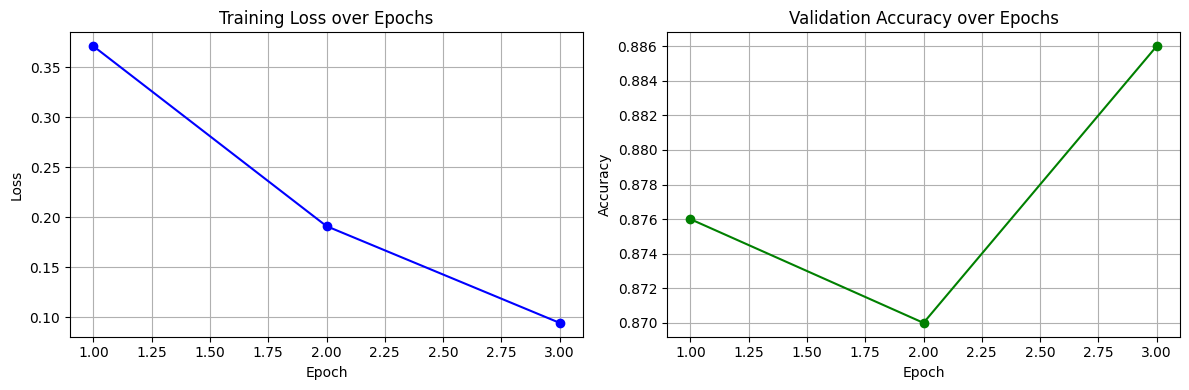

In [24]:
# Loss curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_accuracies, 'g-o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.grid(True)

plt.tight_layout()
plt.show()

## Task 4: Model Efficiency Analysis


In [25]:
# Load second model for comparison
comparison_model_name = "bert-base-uncased"
comparison_model = AutoModelForSequenceClassification.from_pretrained(comparison_model_name, num_labels=num_labels)
comparison_model.to(device)
comparison_model.eval()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [30]:
# Function to measure inference time
def measure_inference_time(model, dataloader, num_batches=20):
    inference_times = []

    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            if idx >= num_batches:
                break

            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            start_time = time.time()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            inference_time = time.time() - start_time

            inference_times.append(inference_time / len(input_ids))

    return np.mean(inference_times)

In [31]:
# Measure for both models
print("\nMeasuring inference times...")

distilbert_time = measure_inference_time(model, test_loader)
bert_time = measure_inference_time(comparison_model, test_loader)

# Model parameters
distilbert_params = sum(p.numel() for p in model.parameters())
bert_params = sum(p.numel() for p in comparison_model.parameters())

# Model sizes
distilbert_size = (distilbert_params * 4) / (1024 ** 2)
bert_size = (bert_params * 4) / (1024 ** 2)


Measuring inference times...


In [34]:
# Print comparison
print(f"\nModel Comparison:")
print(f"{'Metric':<30} {'DistilBERT':<20} {'BERT':<20}")
print(f"{'Parameters':<30} {distilbert_params:,<20} {bert_params:,<20}")
print(f"{'Model Size (MB)':<30} {distilbert_size:<20.2f}{bert_size:<20.2f}")
print(f"{'Inference Time (ms)':<30} {distilbert_time*1000:<20.2f} {bert_time*1000:<20.2f}")
print(f"{'Speedup':<30} {bert_time/distilbert_time:<20.2f}x")



Model Comparison:
Metric                         DistilBERT           BERT                
Parameters                     66955010,,,,,,,,,,,, 109483778,,,,,,,,,,,
Model Size (MB)                255.41              417.65              
Inference Time (ms)            0.55                 1.35                
Speedup                        2.47                x
